<a href="https://colab.research.google.com/github/ispapadakis/pytorch-generative-adversarial-networks/blob/master/GAN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN)
## Simple PyTorch Example

Based on:

https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9

** Question: ** Original GAN Success Rate is 8/10. Can this be improved while the model remains parsimonious?

# Research 2 Strategies
### I. Use Original Method (4 Moments) with Modifications
- Simulate Triangular Distribution, not Gaussian (Triangular has fixed tails)
- Increase Skewness Weight
- Modify optimizer settings (SGD momentum)

### II. Measure Distribution by Conditional Expectations
- Simulate Triangular Distribution, not Gaussian (Triangular has fixed tails)
- Define Conditional Expectations using Torch clamp function, a variant of ReLU. Apply weights to increase their gradient close to boundary points.
- Modify optimizer settings (SGD momentum)

# RESULTS
Measure success rate as done in our reference:
- Observe distribution of "fake" images after 10 replications (each replication ends after 5,000 epochs)
- Visually inspect "fake" image distribution histograms. 
- Report how many times "fake" distributions would pass for triangular

## I. 4-Moments Method
Success here is literally in the eye of the beholder. All resulting "fake" distributions have a mode at their center, which is close to 4. They lie far from the original of a uniform distribution and much closer to the triangular distribution.

We call the sucess rate here **9.25/10**. We deem 0.50 points as lost in replication 1, where the right tail is too fat for triangular. Also, 0.25 points are lost in replication 6, as both tails are excessively fat.

## II. Conditional Expectations
Again, the Generator part of GAN creates "fake" distributions with mode at 4, as desired. We call the success rate here **9.50/10**. In many cases, the resulting distributions show higher kurtosis than expected from a triangular distribution. Overall, Conditional Expectations appear to add to the reliability of this GAN.



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from matplotlib import pyplot as plt

In [0]:
import warnings

#warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

## Data params

In [0]:
data_mean = 4
data_stddev = 1.25

Uncomment only one of these to define what data is actually sent to the Discriminator

In [43]:
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
(name, preprocess, d_input_func) = ("Include Conditional Expectations", lambda data: conditional_expectations(data), lambda x: 9)

print("Method [%s]" % (name))

Method [Include Conditional Expectations]


In [0]:
# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    #return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian
    return lambda n: torch.Tensor(np.random.triangular(mu-2*sigma, mu, mu+2*sigma, (1, n)))  # Triangular
  
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [0]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = 3 * torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0))
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final
  
def conditional_expectations(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = 3 * torch.mean(torch.pow(zscores, 3.0))
    cn0 = 2 * torch.mean(torch.clamp(10*zscores,-5,0)) / 10
    cp0 = 2 * torch.mean(torch.clamp(10*zscores,0,5)) / 10
    cn1 = 2 * torch.mean(torch.clamp(10*zscores,-10,-5)) / 10
    cp1 = 2 * torch.mean(torch.clamp(10*zscores,5,10)) / 10
    cn2 = 2 * torch.mean(torch.clamp(10*zscores,-100,-10)) / 10
    cp2 = 2 * torch.mean(torch.clamp(10*zscores,10,100)) / 10

    final = torch.cat((mean.reshape(1,), 
                       std.reshape(1,), skews.reshape(1,), 
                       cn0.reshape(1,), cp0.reshape(1,), 
                       cn1.reshape(1,), cp1.reshape(1,),
                       cn2.reshape(1,), cp2.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)



Epoch    0: D (0.803 real_err, 0.598 fake_err) G (0.799 err)
Real Dist (3.953,0.996),  Fake Dist (0.445,0.033) 


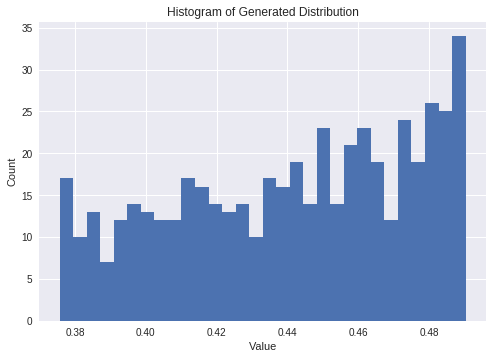


Epoch  500: D (0.696 real_err, 0.698 fake_err) G (0.691 err)
Real Dist (4.076,0.973),  Fake Dist (4.072,0.555) 


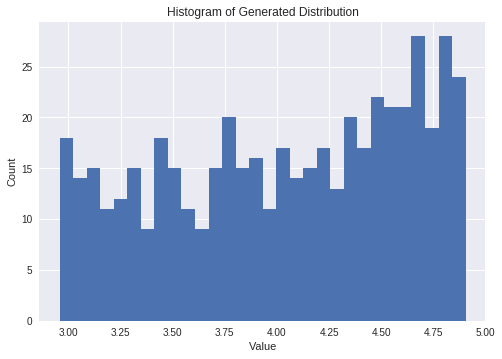


Epoch 1000: D (0.688 real_err, 0.695 fake_err) G (0.695 err)
Real Dist (3.976,1.044),  Fake Dist (3.350,0.955) 


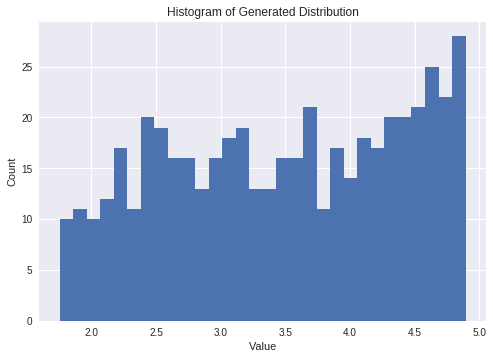


Epoch 1500: D (0.691 real_err, 0.693 fake_err) G (0.695 err)
Real Dist (3.988,0.975),  Fake Dist (3.921,1.073) 


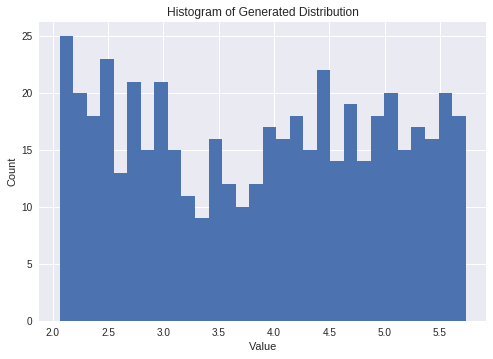


Epoch 2000: D (0.693 real_err, 0.691 fake_err) G (0.695 err)
Real Dist (3.952,1.062),  Fake Dist (4.014,1.030) 


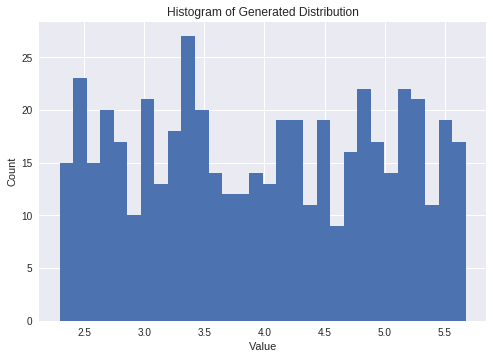


Epoch 2500: D (0.690 real_err, 0.688 fake_err) G (0.702 err)
Real Dist (3.987,1.063),  Fake Dist (4.054,1.038) 


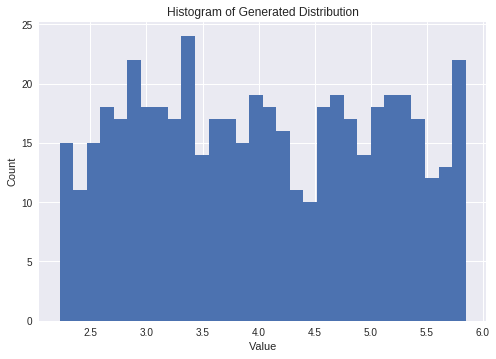


Epoch 3000: D (0.670 real_err, 0.688 fake_err) G (0.691 err)
Real Dist (4.009,1.019),  Fake Dist (3.575,1.093) 


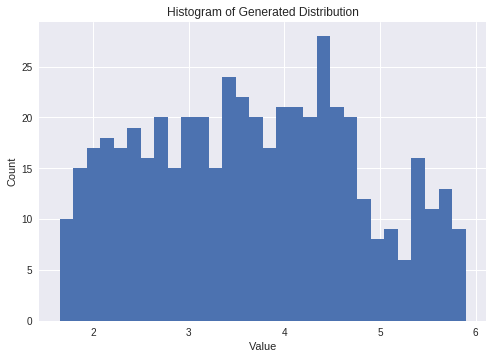


Epoch 3500: D (0.696 real_err, 0.695 fake_err) G (0.692 err)
Real Dist (4.029,1.014),  Fake Dist (4.300,1.097) 


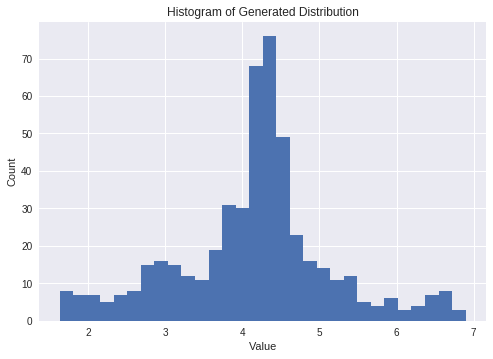


Epoch 4000: D (0.694 real_err, 0.694 fake_err) G (0.692 err)
Real Dist (3.917,1.032),  Fake Dist (4.155,1.125) 


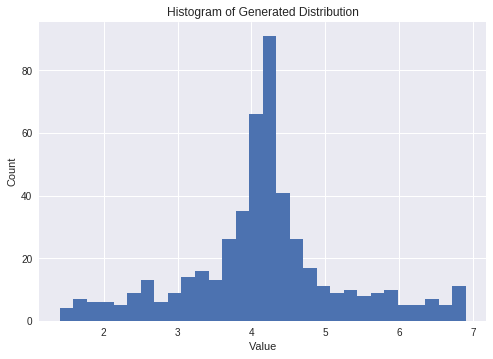


Epoch 4500: D (0.694 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.974,1.046),  Fake Dist (4.096,1.071) 


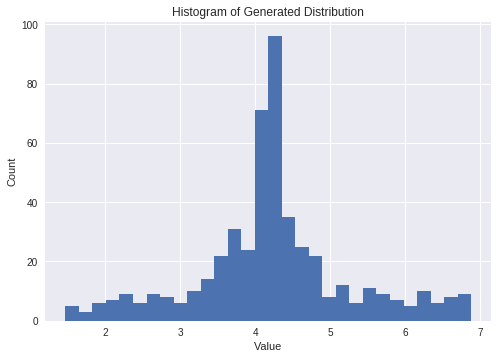


Epoch 5000: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.986,1.024),  Fake Dist (3.990,1.062) 


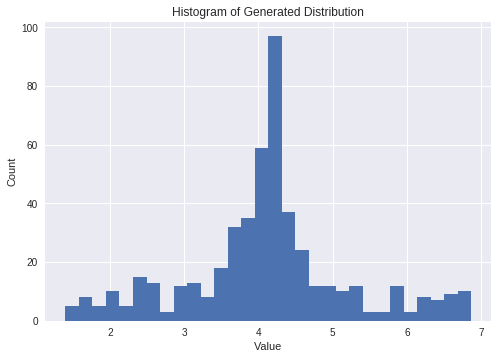

In [53]:
# Model parameters
g_input_size = 1      # Random noise dimension coming into generator, per output vector
g_hidden_size = 5     # Generator complexity
g_output_size = 1     # Size of generated output vector
d_input_size = 500    # Minibatch size - cardinality of distributions
d_hidden_size = 10    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
minibatch_size = d_input_size

d_learning_rate = 1e-3
g_learning_rate = 1e-3
sgd_momentum = 0.90

num_epochs = 5001
print_interval = 500
d_steps = 20
g_steps = 20

dfe, dre, ge = 0, 0, 0
d_real_data, d_fake_data, g_fake_data = None, None, None

discriminator_activation_function = torch.sigmoid
generator_activation_function = torch.tanh

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              output_size=g_output_size,
              f=generator_activation_function)
D = Discriminator(input_size=d_input_func(d_input_size),
                  hidden_size=d_hidden_size,
                  output_size=d_output_size,
                  f=discriminator_activation_function)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

for epoch in range(num_epochs):
  for d_index in range(d_steps):
      # 1. Train D on real+fake
      D.zero_grad()

      #  1A: Train D on real
      d_real_data = Variable(d_sampler(d_input_size))
      d_real_decision = D(preprocess(d_real_data))
      d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
      d_real_error.backward() # compute/store gradients, but don't change params

      #  1B: Train D on fake
      d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
      d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
      d_fake_decision = D(preprocess(d_fake_data.t()))
      d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
      d_fake_error.backward()
      d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

      dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

  for g_index in range(g_steps):
      # 2. Train G on D's response (but DO NOT train D on these labels)
      G.zero_grad()

      gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
      g_fake_data = G(gen_input)
      dg_fake_decision = D(preprocess(g_fake_data.t()))
      g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

      g_error.backward()
      g_optimizer.step()  # Only optimizes G's parameters
      ge = extract(g_error)[0]

  if epoch % print_interval == 0:
    print("\nEpoch %4d: D (%5.3f real_err, %5.3f fake_err) G (%5.3f err)\nReal Dist (%s),  Fake Dist (%s) " %
            (epoch, dre, dfe, ge, ",".join("%5.3f" % s for s in stats(extract(d_real_data))), 
             ",".join("%5.3f" % s for s in stats(extract(d_fake_data))) ))

    #print("Plotting the generated distribution...")
    values = extract(g_fake_data)
    #print(" Values: %s" % (str(values)))
    plt.hist(values, bins=30)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Histogram of Generated Distribution')
    plt.grid(True)
    plt.show()

# 4 Moments Method: Repeat Process 10 Times
## Observe if Generator succeeds in creating reasonably triangular distributions

Using data [Only 4 moments]

Repetition  1/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.923,1.011),  Fake Dist (3.999,0.977) 


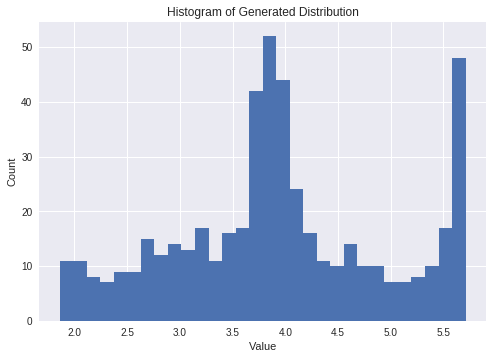


Repetition  2/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.694 err)
Real Dist (3.969,1.013),  Fake Dist (4.000,1.046) 


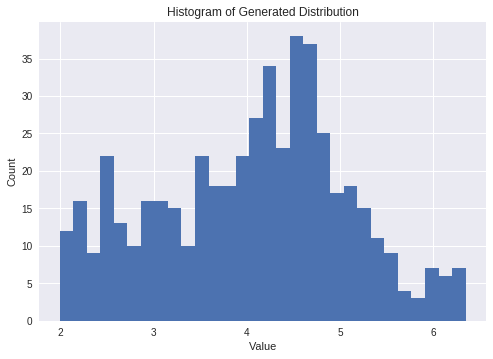


Repetition  3/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (4.024,1.002),  Fake Dist (4.014,0.977) 


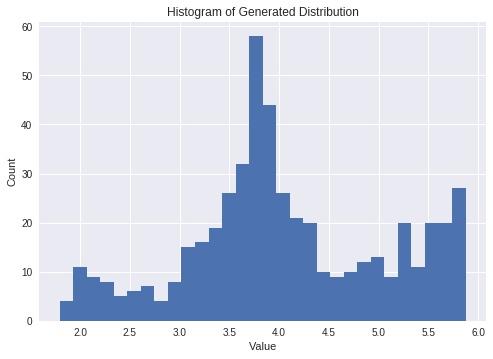


Repetition  4/10

Epoch 4999: D (0.694 real_err, 0.696 fake_err) G (0.693 err)
Real Dist (3.918,1.037),  Fake Dist (3.981,1.004) 


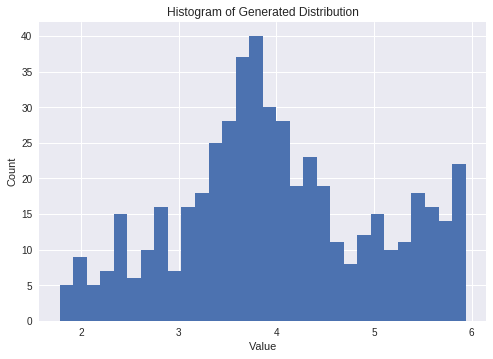


Repetition  5/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.967,1.039),  Fake Dist (4.010,1.018) 


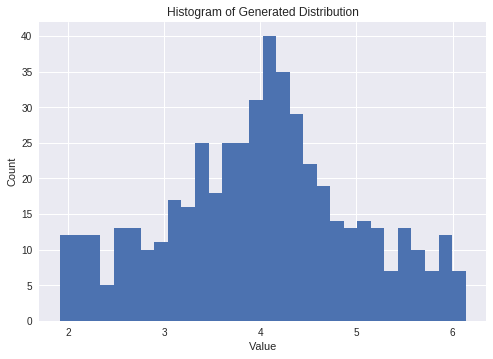


Repetition  6/10

Epoch 4999: D (0.694 real_err, 0.691 fake_err) G (0.693 err)
Real Dist (4.052,1.040),  Fake Dist (3.980,1.115) 


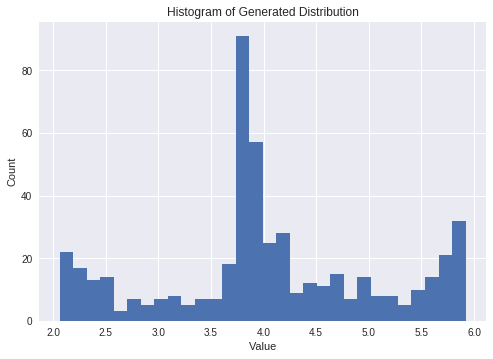


Repetition  7/10

Epoch 4999: D (0.694 real_err, 0.694 fake_err) G (0.693 err)
Real Dist (4.091,1.020),  Fake Dist (3.966,1.011) 


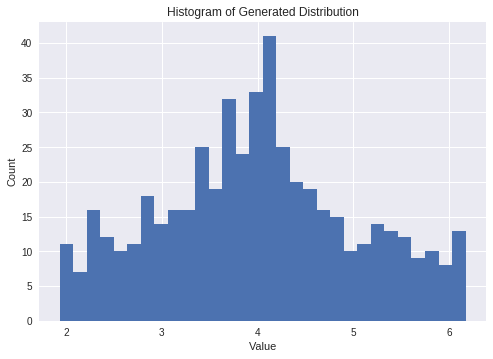


Repetition  8/10

Epoch 4999: D (0.694 real_err, 0.695 fake_err) G (0.692 err)
Real Dist (3.992,1.002),  Fake Dist (4.016,0.996) 


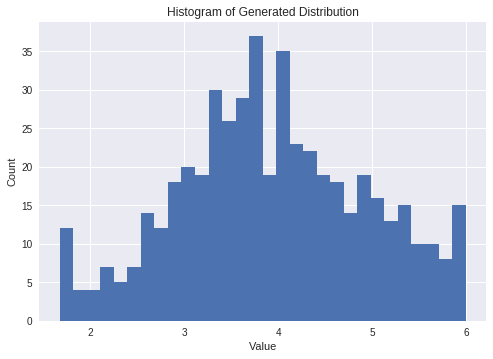


Repetition  9/10

Epoch 4999: D (0.694 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (4.003,1.016),  Fake Dist (4.978,0.010) 


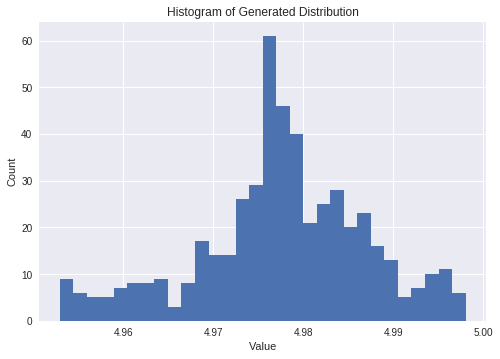


Repetition 10/10

Epoch 4999: D (0.692 real_err, 0.693 fake_err) G (0.692 err)
Real Dist (4.071,1.003),  Fake Dist (3.959,0.968) 


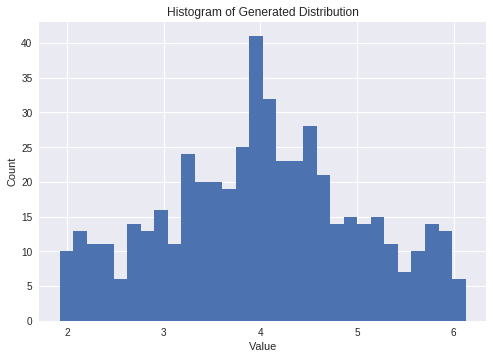

In [30]:
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Method [%s]" % (name))

d_learning_rate = 1e-3
g_learning_rate = 1e-3
sgd_momentum = 0.92


nrep = 10
num_epochs = 5000

for rep in range(nrep):

  
  dfe, dre, ge = 0, 0, 0
  d_real_data, d_fake_data, g_fake_data = None, None, None

  discriminator_activation_function = torch.sigmoid
  generator_activation_function = torch.tanh

  d_sampler = get_distribution_sampler(data_mean, data_stddev)
  gi_sampler = get_generator_input_sampler()
  G = Generator(input_size=g_input_size,
                hidden_size=g_hidden_size,
                output_size=g_output_size,
                f=generator_activation_function)
  D = Discriminator(input_size=d_input_func(d_input_size),
                    hidden_size=d_hidden_size,
                    output_size=d_output_size,
                    f=discriminator_activation_function)
  criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
  d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
  g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

  print('\nRepetition {:2d}/{:2d}'.format(rep+1,nrep))

  for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        ge = extract(g_error)[0]

    if epoch + 1 == num_epochs:
      print("\nEpoch %4d: D (%5.3f real_err, %5.3f fake_err) G (%5.3f err)\nReal Dist (%s),  Fake Dist (%s) " %
              (epoch, dre, dfe, ge, ",".join("%5.3f" % s for s in stats(extract(d_real_data))), 
               ",".join("%5.3f" % s for s in stats(extract(d_fake_data))) ))

      #print("Plotting the generated distribution...")
      values = extract(g_fake_data)
      #print(" Values: %s" % (str(values)))
      plt.hist(values, bins=30)
      plt.xlabel('Value')
      plt.ylabel('Count')
      plt.title('Histogram of Generated Distribution')
      plt.grid(True)
      plt.show()

# Conditional Expectations Method: Repeat Process 10 Times
## Observe if Generator succeeds in creating reasonably triangular distributions

Method [Include Conditional Expectations]

Repetition  1/10

Epoch 4999: D (0.693 real_err, 0.694 fake_err) G (0.693 err)
Real Dist (3.993,0.979),  Fake Dist (3.944,1.044) 


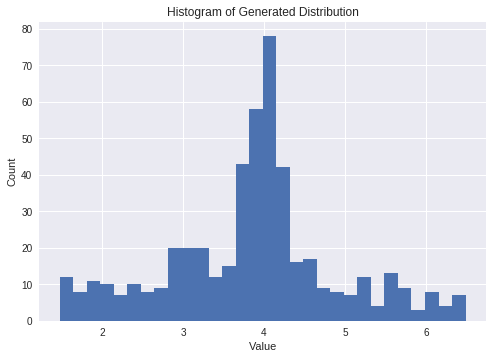


Repetition  2/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (4.040,1.045),  Fake Dist (4.051,1.152) 


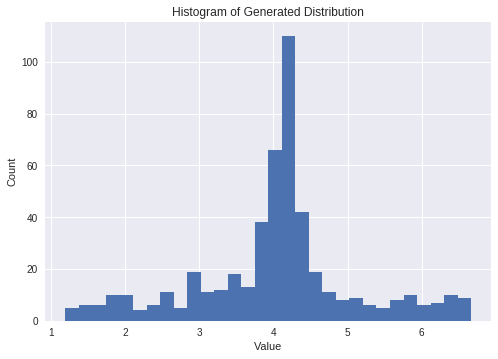


Repetition  3/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.694 err)
Real Dist (3.944,1.000),  Fake Dist (4.315,2.233) 


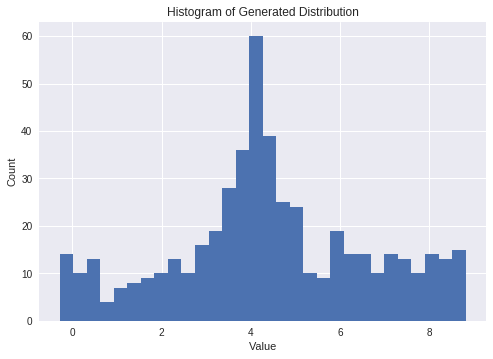


Repetition  4/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (4.048,0.987),  Fake Dist (3.935,1.023) 


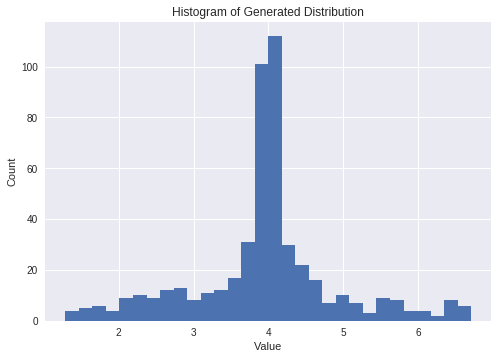


Repetition  5/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.963,1.017),  Fake Dist (3.990,0.974) 


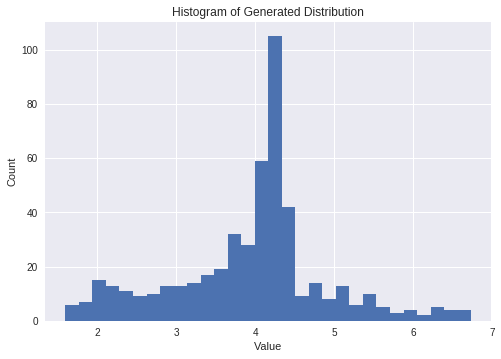


Repetition  6/10

Epoch 4999: D (0.692 real_err, 0.695 fake_err) G (0.691 err)
Real Dist (4.033,1.027),  Fake Dist (3.983,0.972) 


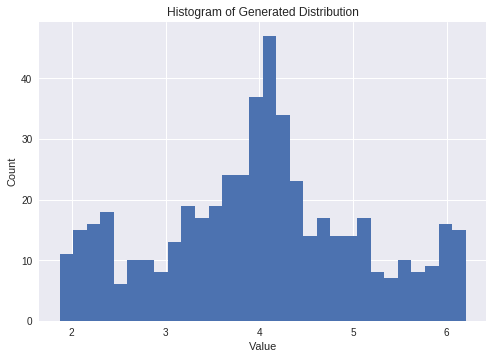


Repetition  7/10

Epoch 4999: D (0.696 real_err, 0.690 fake_err) G (0.690 err)
Real Dist (3.927,1.006),  Fake Dist (3.978,0.990) 


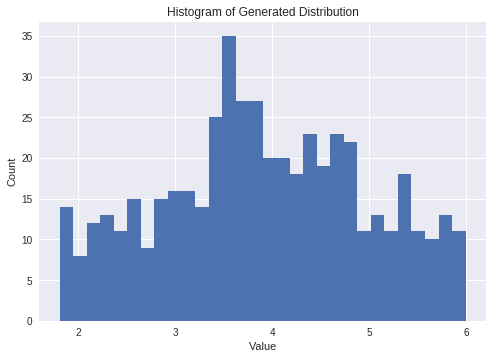


Repetition  8/10

Epoch 4999: D (0.694 real_err, 0.690 fake_err) G (0.698 err)
Real Dist (3.963,1.043),  Fake Dist (3.959,1.030) 


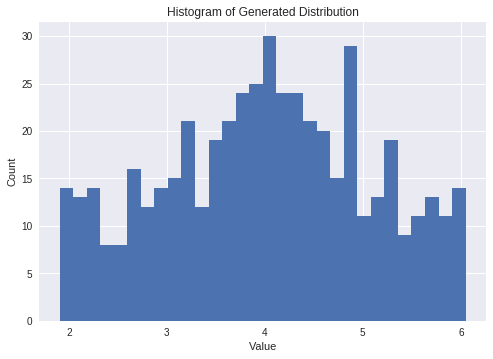


Repetition  9/10

Epoch 4999: D (0.693 real_err, 0.693 fake_err) G (0.693 err)
Real Dist (3.966,0.972),  Fake Dist (3.930,1.071) 


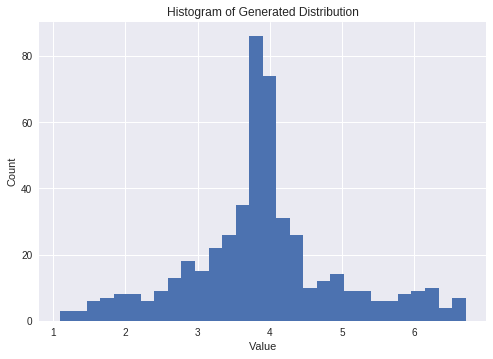


Repetition 10/10

Epoch 4999: D (0.685 real_err, 0.688 fake_err) G (0.693 err)
Real Dist (3.941,1.025),  Fake Dist (3.891,1.023) 


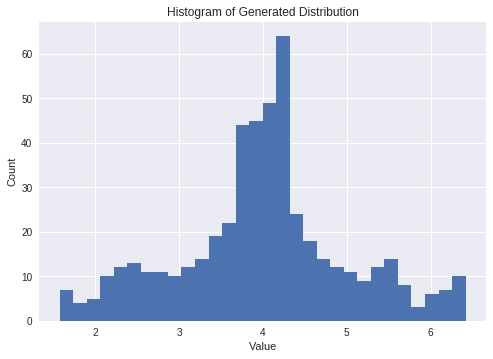

In [35]:
(name, preprocess, d_input_func) = ("Include Conditional Expectations", lambda data: conditional_expectations(data), lambda x: 9)


print("Method [%s]" % (name))

d_learning_rate = 1e-3
g_learning_rate = 1e-3
sgd_momentum = 0.90


nrep = 10
num_epochs = 5000

for rep in range(nrep):

  
  dfe, dre, ge = 0, 0, 0
  d_real_data, d_fake_data, g_fake_data = None, None, None

  discriminator_activation_function = torch.sigmoid
  generator_activation_function = torch.tanh

  d_sampler = get_distribution_sampler(data_mean, data_stddev)
  gi_sampler = get_generator_input_sampler()
  G = Generator(input_size=g_input_size,
                hidden_size=g_hidden_size,
                output_size=g_output_size,
                f=generator_activation_function)
  D = Discriminator(input_size=d_input_func(d_input_size),
                    hidden_size=d_hidden_size,
                    output_size=d_output_size,
                    f=discriminator_activation_function)
  criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
  d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
  g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

  print('\nRepetition {:2d}/{:2d}'.format(rep+1,nrep))

  for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        ge = extract(g_error)[0]

    if epoch + 1 == num_epochs:
      print("\nEpoch %4d: D (%5.3f real_err, %5.3f fake_err) G (%5.3f err)\nReal Dist (%s),  Fake Dist (%s) " %
              (epoch, dre, dfe, ge, ",".join("%5.3f" % s for s in stats(extract(d_real_data))), 
               ",".join("%5.3f" % s for s in stats(extract(d_fake_data))) ))

      #print("Plotting the generated distribution...")
      values = extract(g_fake_data)
      #print(" Values: %s" % (str(values)))
      plt.hist(values, bins=30)
      plt.xlabel('Value')
      plt.ylabel('Count')
      plt.title('Histogram of Generated Distribution')
      plt.grid(True)
      plt.show()